###### Name: Crystal Lau
###### Date: 05/07/2018
###### Python 3.6.2

# Thinkful Prep-Course Capstone: What is killing America? A look at the numbers behind American mortality

This dataset is taken from National Center for Health Statistics (NCHS) and can be found __[here](https://catalog.data.gov/dataset/age-adjusted-death-rates-for-the-top-10-leading-causes-of-death-united-states-2013)__. It catalogues the 10 leading causes of death in the United States from 1999-2015. It was compiled on December 16, 2015 and last updated April 8, 2018. I find it an interesting dataset as it provides tangible numbers to reflect the current picture of mortality in the US and can potentially be used to make informed, data-driven decisions about NIH funding allocation.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt
%matplotlib inline

master_death_df = pd.read_csv('NCHS_-_Leading_Causes_of_Death__United_States.csv')

### Summary Statistics
This dataset is organized by columns into: 'Year', '113 Cause Name', 'Cause Name', 'State', 'Deaths', and 'Age-adjusted Death Rate'. There two columns for cause names, one ('113 Cause Name') abides by the ICD-10 __[International Classification of Diseases](http://www.who.int/classifications/icd/en/)__ code conventions and the other documents the underlying cause of death over time (can be something that occured hours before or documented medical condition).  For the purposes of this analysis, the underlying cause of death will be used as the determinant. The population information comes from their corresponding U.S. Census, which is taken every ten years. Pre-2010 population data is based on intercensal estimates and the 2000 U.S. Census and anything post-2010 is base on post-censal estimates. Data on the deaths per state per year are based on resident death certificates filed in the 50 states and D.C. The age-adjusted death rate helps to account for the age distribution of the deceased and is measured by looking at the number of deaths in an age group per 100,000 people. This helps to give a weighted overview of the numbers presented.

**age-adjusted death rate** = $\sum{standard population * ASDR(Age-specificdeathrate)}$

In [27]:
# sample of what data set looks like raw
master_death_df.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,Alabama,2313.0,52.2
1,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,Alaska,294.0,55.9
2,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,Arizona,2214.0,44.8
3,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,Arkansas,1287.0,47.6
4,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,California,9198.0,28.7


#### Caveat
It is useful to note that dataset may be an incomplete representation as it only draws from resident death certificates filed, unaccounting for deaths that are not. Populations such as undocumented immigrants are likely unaccounted for. Some other things to keep in mind are that mortality documentation in and of itself is a problematic __[field to study](https://www.pbs.org/wgbh/pages/frontline/post-mortem/real-csi/)__. Some complications include NCHS's lack of funds to acquire all the records each state has to offer, inaccuracy in documenting cause of death without an autopsy performed, and the laborious process of getting the death certificate amended in the case that cause of death is incorrect. However, given that this is the same data that the CDC uses to conduct their funding analyses, it's good enough for us in the context of this analyses.

In [2]:
# shape of the dataset (rows, columns)
master_death_df.shape

(15028, 6)

In [3]:
# names and data types of columns
master_death_df.dtypes

Year                         int64
113 Cause Name              object
Cause Name                  object
State                       object
Deaths                     float64
Age-adjusted Death Rate    float64
dtype: object

In [4]:
# High-level statistical overview of information in dataset by columns
# Statistics on year is irrelevant
master_death_df.describe()

,Year,Deaths,Age-adjusted Death Rate
count,15028.000000,1.501300e+04,14917.000000
mean,2007.000000,1.023261e+04,86.526393
std,4.899142,9.003261e+04,190.764950
min,1999.000000,1.000000e+01,1.300000
25%,2003.000000,2.940000e+02,8.300000
50%,2007.000000,8.380000e+02,18.900000
75%,2011.000000,2.737000e+03,46.300000
max,2015.000000,2.712630e+06,1087.300000


In [5]:
# List of Top 10 Causes 1999-2015 (not in the order of prevalence)
causes = np.unique(master_death_df[(master_death_df['Cause Name'] != 'All Causes')]['Cause Name'])
pd.DataFrame(causes)

,0
0,Alzheimer's disease
1,CLRD
2,Cancer
3,Chronic liver disease and cirrhosis
4,Diabetes
5,Diseases of Heart
6,Essential hypertension and hypertensive renal ...
7,Homicide
8,Influenza and pneumonia
9,Kidney Disease


There are more than 10 listed here because the top 10 killers vary year by year.

         Deaths  Age-adjusted Death Rate
Year                                    
1999  2026478.0                  37808.1
2000  2027126.0                  37403.1
2001  2032019.0                  36922.5
2002  2052413.0                  36784.2
2003  2048691.0                  36198.4
2004  1999721.0                  34681.1
2005  2031496.0                  34692.7
2006  1995337.0                  33462.2
2007  1989666.0                  32769.1
2008  2019527.0                  32637.2
2009  1983736.0                  31442.8
2010  2000983.0                  31324.9
2011  2024091.0                  30927.0
2012  2034918.0                  30380.3
2013  2075560.0                  30346.7
2014  2106553.0                  30281.9
2015  2191884.0                  30905.7


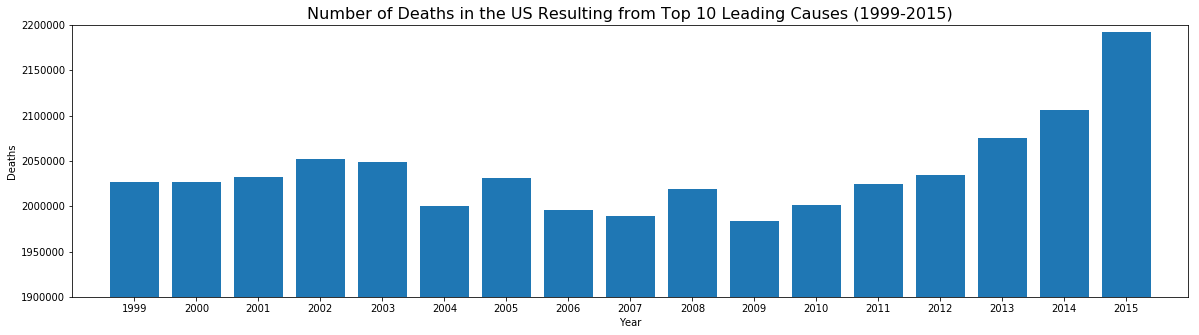

In [29]:
# Total Deaths for Each Year
grouped_year = master_death_df[(master_death_df['Cause Name'] != 'All Causes') & 
                               (master_death_df['State'] !='United States')].groupby(['Year']).sum()
plt.bar(grouped_year.index, grouped_year['Deaths'])
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.title('Number of Deaths in the US Resulting from Top 10 Leading Causes (1999-2015)', fontsize=16)
plt.xticks(grouped_year.index)
plt.axis([1998, 2016, 1900000, 2200000])
plt.rcParams['figure.figsize']=(20,5)
plt.show()

The major questions that will be explored:
- What are the leading (top 2-3) causes of death for the American population and which one to delve into given the limited scope of this project.
- What is the current landscape for the aforementioned cause of death in the US?
- Which states appear to be outliers and how do they compare to the national trend?

### Which cause of deaths are accoutable for the largest number of deaths in the US?

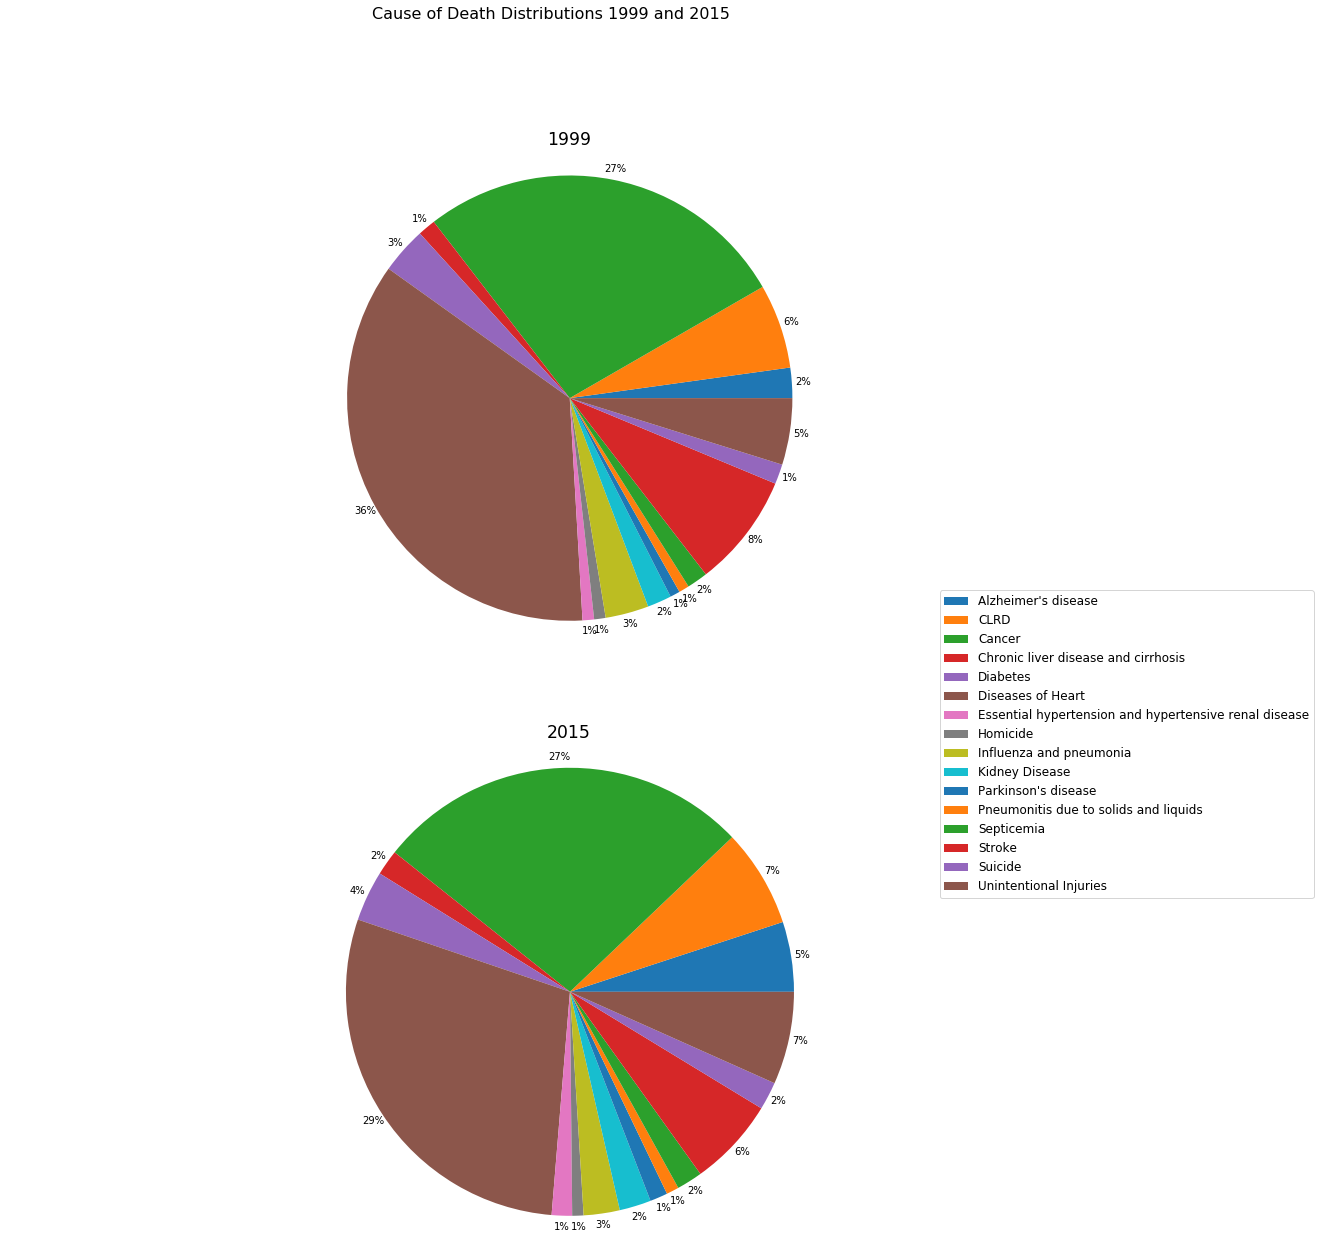

In [25]:
# Pie chart comparing the cause of death distribution for 1999 and 2015 respectively
master_death_df.loc[lambda df: (master_death_df['Year'] == 1999) & 
                               (master_death_df['Cause Name'] != 'All Causes'), :]
year_1999 = master_death_df.loc[lambda df: (master_death_df['Year'] == 1999) & 
                                           (master_death_df['Cause Name'] != 'All Causes'), :]
year_1999_sums = year_1999.groupby(['Cause Name']).sum()

year_2015 = master_death_df.loc[lambda df: (master_death_df['Year'] == 2015) & 
                                           (master_death_df['Cause Name'] != 'All Causes'), :]
year_2015_sums = year_2015.groupby(['Cause Name']).sum()

# 1999 Pie
plt.subplot(2,1,1)
plt.title('1999', fontsize='xx-large')
plt.pie(year_1999_sums['Deaths'], autopct='%1.f%%', pctdistance=1.05, radius=3)
plt.axis("equal")


# 2015 Pie
plt.subplot(2,1,2)
plt.title('2015', fontsize='xx-large')
plt.pie(year_2015_sums['Deaths'], autopct='%1.f%%', pctdistance=1.05, radius=3)
plt.axis("equal")

plt.legend(year_2015_sums.index, loc='center', bbox_to_anchor=(1, 1), fontsize='large')
plt.suptitle('Cause of Death Distributions 1999 and 2015', fontsize=16)
plt.rcParams['figure.figsize']=(20,20)
plt.show()

Heart disease and cancer are the top two causes of death in United States. Heart disease continues to be the major killer over the span of 16 years, accounting for 36% of deaths in 1999 and 29% of deaths in 2015, while cancer appears to have not changed, sitting at 27% for both years. Since there appears to be a significant drop in the percentage for heart disease and yet accounts for the most amount of deaths, it is intriguing enough to delve deeper into what the numbers can tell us about it.

To continue to select sub-groups of data to study without have to continuously rewrite the same queries, here's a function that can quickly return a dataframe with given parameters:

In [10]:
# method to return a dataframe with given state and death cause parameters
# default to 1999, United States, and All Causes if no other parameters given
def data_select(df, state = 'United States', cause = 'All Causes'):
    return df.loc[lambda df:(df['State'] == state) & (df['Cause Name'] == cause)]

### What is the current landscape of heart disease mortality in the US?

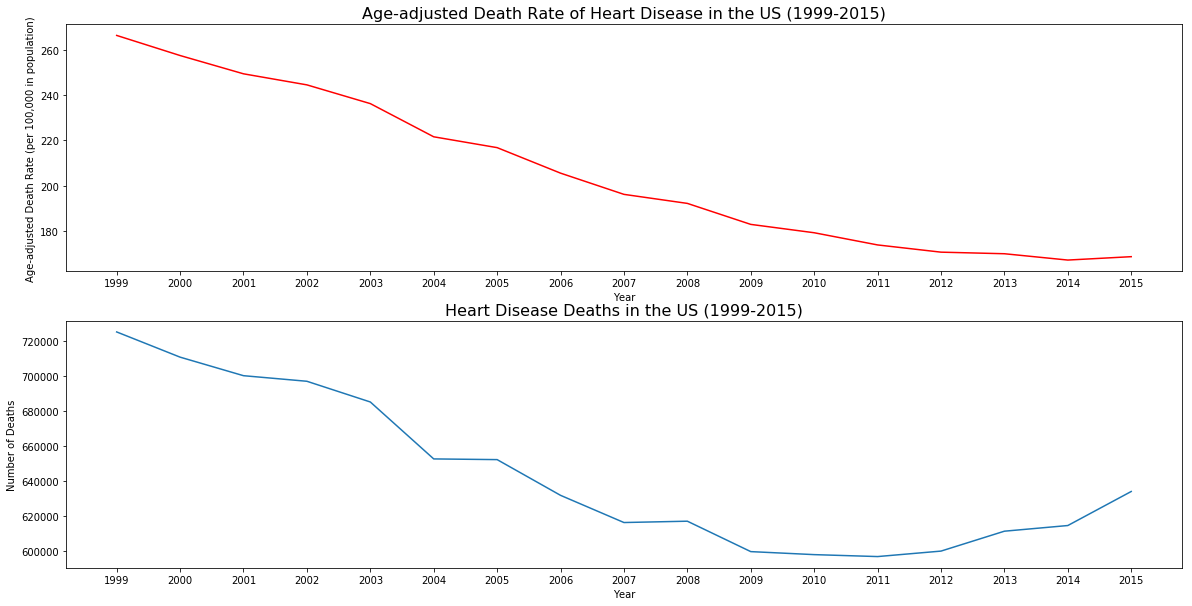

In [12]:
heart_df = data_select(master_death_df, 'United States', 'Diseases of Heart')

# plotting trend of age-adjusted death rate of Heart Disease in the US (1999-2015)
plt.subplot(2,1,1)
plt.plot(heart_df['Year'], heart_df['Age-adjusted Death Rate'], color='red')
plt.xticks(heart_df['Year'])
plt.xlabel('Year')
plt.ylabel('Age-adjusted Death Rate (per 100,000 in population)')
plt.title('Age-adjusted Death Rate of Heart Disease in the US (1999-2015)', fontsize=16)

# plotting trend of number of deaths due to Heart Disease in the US (1999-2015)
plt.subplot(2,1,2)
plt.plot(heart_df['Year'], heart_df['Deaths'])
plt.xticks(heart_df['Year'])
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.title('Heart Disease Deaths in the US (1999-2015)', fontsize=16)

plt.rcParams['figure.figsize'] = (20, 10)
plt.show()

The overall trend of the age-adjusted death rate due to heart disease appears to be steadily decreasing over the years. However, in the number of deaths, from 2012-2015 we see a jump in the number of deaths related to heart disease despite the steady decrease of the death rate. One hypothesis could be that the age-adjusted death rate helps neutralize the effect of a large number of deaths in a certain age group skewing the result. Many of the baby boomers born in the 1950s would have reached their 60s around 2012 which could account for the increase in the number of deaths as according this __[Harvard Men's Health Review](https://www.health.harvard.edu/heart-health/premature-heart-disease)__, 65 is the average age when men have their first heart attack. But there is no further data available in this dataset to come to a verfiable conclusion.

### Which states have the highest/lowest age-adjusted death rate and how does it compare to the national trend?

In [13]:
heart_state_df = master_death_df.loc[lambda df: (master_death_df['Cause Name'] == 'Diseases of Heart') &
                                            (master_death_df['State'] != 'United States')]

In [19]:
# state with highest age-adjusted death rate for heart disease
heart_state_df.loc[lambda df: (heart_state_df['Age-adjusted Death Rate'] == heart_state_df['Age-adjusted Death Rate'].max())]

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
7096,1999,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,Mississippi,9336.0,347.4


In [20]:
# state with lowest age-adjusted death rate for heart disease
heart_state_df.loc[lambda df: (heart_state_df['Age-adjusted Death Rate'] == heart_state_df['Age-adjusted Death Rate'].min())]

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
7875,2014,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,Minnesota,7659.0,116.5


In [21]:
# creating data frames with Mississippi and Minnesota data
heart_ms = data_select(master_death_df, 'Mississippi', 'Diseases of Heart')
heart_mn = data_select(master_death_df, 'Minnesota', 'Diseases of Heart')

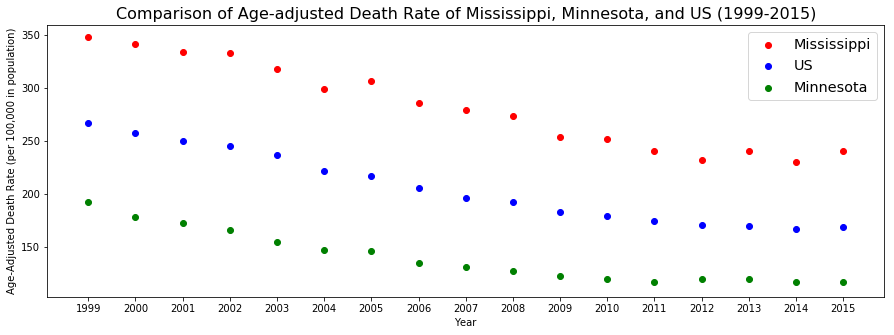

In [23]:
# plot comparing age-adjusted death rate of Mississippi, Minnesota and the US
plt.scatter(heart_ms['Year'], heart_ms['Age-adjusted Death Rate'], color='red', label='Mississippi')
plt.scatter(heart_df['Year'], heart_df['Age-adjusted Death Rate'], color='blue', label='US')
plt.scatter(heart_mn['Year'], heart_mn['Age-adjusted Death Rate'], color='green', label='Minnesota')
plt.xticks(heart_df['Year'])
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Death Rate (per 100,000 in population)')
plt.legend(fontsize='x-large')
plt.title('Comparison of Age-adjusted Death Rate of Mississippi, Minnesota, and US (1999-2015)', fontsize=16)

plt.rcParams['figure.figsize'] = (15, 5)
plt.show()

From this plot, we can see that the overall Mississippi's death rate due to heart disease is higher than the national trend whereas Minnesota's is lower per 100,000 people in their respective populations.

In [32]:
from scipy.stats import ttest_ind

ttest_ind(heart_ms['Age-adjusted Death Rate'], heart_mn['Age-adjusted Death Rate'], equal_var=False)

Ttest_indResult(statistic=12.204439815776947, pvalue=2.875694090584534e-12)

## Conclusions

There are significant implications that were performed on this dataset. Minnesota's death rate due to heart disease is significantly lower than that of the national rate. Perhaps a next step to this analyses could be to look at the healthcare policies and regulations that Minnesota implements. From there, those approaches could be adopted on a national level to continue to curb the death rate of heart disease - the biggest, baddest cause of death to the American population.

## Further Applications


On a broader scale, we can also identify the major killers specific to each state and tailor research needs to reflect where the need is on a state level.

Some important questions to ask would include:
- What does the current distribution of NIH funding to healthcare research look like?
- How much funding is allocated to the disease or cause of interest compared to others?
- How does that distribution look like next to the impact of the disease nationwide?

To implement this proposal:
- Do some summary statistics on the NIH reports to get an overview of what NIH funding looks like, how it's organized.
- Isolate the numbers related to research funding to the disease/cause of choice (i.e. heart disease) and load it into a dataframe
- From there, can go state-specific or disease specific (i.e. heart disease funding in Minnesota vs Mississippi)

A whopping __[$37.3 billion](https://www.nih.gov/about-nih/what-we-do/budget)__ is allocated to the NIH to disperse to different research initiatives. Using this data in conjunction with what we can find from __[NIH reports](https://report.nih.gov/nih_funding.aspx)__, we can speculate whether appropriate funds are being allocated to the right places and propose ammendments if not.